# Sea Level Rise AR5
Notebook environment to migrate netcdf files to CF compliant zarr & CoG

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import numpy.ma as ma
import rasterio
import rioxarray as rio


# Make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# Get root paths
home = pathlib.Path().home()
root = home.root
tmp_dir = home.joinpath("data", "tmp")

# Import custom functionality
from etl import p_drive
from etl.CF_compliancy_checker import check_compliancy, save_compliancy

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11205479-coclico", "FASTTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    home.joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
    )
)

# use local or remote data dir
use_local_data = False
ds_dirname = "18_AR5_SLP_IPCC"

if use_local_data: 
    ds_dir = tmp_dir.joinpath(ds_dirname)
else: 
    ds_dir = coclico_data_dir.joinpath(ds_dirname)

if not ds_dir.exists():
    raise FileNotFoundError("Directory with data does not exist.")

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog")
cog_dir.mkdir(parents=True, exist_ok=True)

C:\Users\kras\AppData\Local\Temp\ipykernel_10212\407989714.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [4]:
BOUNDS = 0
ENSEMBLE = 2
TIME = 0
VARIABLE = "totslr_ens"
RCP = "45"

def get_data_fp(data_dir, rcp_scenario):
    """Function to get the netcdf dataset fp to also keep track of rcp scenario used. """
    return data_dir.joinpath(f"total-ens-slr-{rcp_scenario}-5.nc")

ds_fp = get_data_fp(ds_dir, RCP)
ds = xr.open_dataset(ds_fp)

# make array 2d 
rds = ds.sel({"ens": ENSEMBLE, "bnds":BOUNDS}).isel(time=TIME)[VARIABLE]
rds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
if not rds.rio.crs:
    rds = rds.rio.write_crs("EPSG:4326")

fname = f"{VARIABLE}_rcp{RCP}_bnds{BOUNDS}_ens{ENSEMBLE}_time{TIME}.GeoTiff"
outpath = cog_dir.joinpath(fname)
rds.rio.to_raster(outpath, driver="GTiff")

c:\Users\kras\Anaconda3\envs\geo_env\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'totslr_ens' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\kras\Anaconda3\envs\geo_env\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'totslr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\kras\Anaconda3\envs\geo_env\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'loerr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\Users\kras\Anaconda3\envs\geo_env\lib\site-packages\xarray\conventions.py:551: SerializationWarning: variable 'hierr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<IPython.core.display.Javascript object>

In [6]:
ds

<xarray.Dataset>
Dimensions:     (time: 94, bnds: 2, lat: 180, lon: 360, ens: 21)
Coordinates:
  * time        (time) object 2007-07-02 12:00:00 ... 2100-07-02 12:00:00
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds, ens
Data variables:
    time_bnds   (time, bnds) object ...
    totslr_ens  (ens, time, lat, lon) float32 ...
    totslr      (time, lat, lon) float32 ...
    loerr       (time, lat, lon) float32 ...
    hierr       (time, lat, lon) float32 ...
    modelname   (ens) |S16 ...
Attributes:
    history:     version 5, 27-March-2014
    contact:     mark.carson@zmaw.de
    references:  IPCC AR5 WGI, Chapter 13, and Chapter 13: Supplementary Mate...

<IPython.core.display.Javascript object>

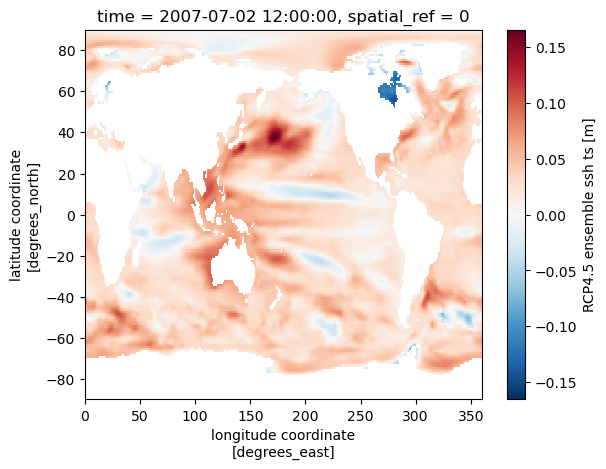

<IPython.core.display.Javascript object>

In [7]:
import rioxarray as rio
data = rio.open_rasterio(outpath, masked=True)
rds.plot()

In [8]:
import xarray as xr
import rioxarray as rio

# data can be downloaded here: https://icdc.cen.uni-hamburg.de/thredds/catalog/ftpthredds/ar5_sea_level_rise/catalog.html?dataset=ftpthreddsscan/ar5_sea_level_rise/total-ens-slr-26-5.nc
ds_xr = xr.open_dataset(ds_dir.joinpath("total-ens-slr-26-5.nc"))
print(list(ds.dims))
print(list(ds.coords))
print(list(ds.variables))

['time', 'bnds', 'lat', 'lon', 'ens']
['time', 'lat', 'lon']
['time', 'time_bnds', 'lat', 'lon', 'totslr_ens', 'totslr', 'loerr', 'hierr', 'modelname']


<IPython.core.display.Javascript object>

NOTE, CODE BELOW WILL GO INTO CONVERTING NETCDFS INTO CF COMPLIANT ZARR FILES. THIS IS NOT NEEDED FOR COGs, LOOK AT DIRECTLY AT 18_slp_stacs.py INSTEAD

In [3]:
# Project paths & files (manual input)
ds_dir = coclico_data_dir.joinpath("18_AR5_SLP_IPCC")
ds_rcp26_path = ds_dir.joinpath("total-ens-slr-26-5.nc")
ds_rcp45_path = ds_dir.joinpath("total-ens-slr-45-5.nc")
ds_rcp85_path = ds_dir.joinpath("total-ens-slr-85-5.nc")
ds_out_file = "total-ens-slr"
CF_dir = coclico_data_dir.joinpath(r"CF")  # directory to save output CF check files

<IPython.core.display.Javascript object>

### Check CF compliancy original NetCDF files

In [31]:
# open datasets
ds_26rcp = xr.open_dataset(ds_rcp26_path)
ds_45rcp = xr.open_dataset(ds_rcp45_path)
ds_85rcp = xr.open_dataset(ds_rcp85_path)

# check original dataset
ds_26rcp

<xarray.Dataset>
Dimensions:     (time: 94, bnds: 2, lat: 180, lon: 360, ens: 16)
Coordinates:
  * time        (time) object 2007-07-02 12:00:00 ... 2100-07-02 12:00:00
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds, ens
Data variables:
    time_bnds   (time, bnds) object ...
    totslr_ens  (ens, time, lat, lon) float32 ...
    totslr      (time, lat, lon) float32 ...
    loerr       (time, lat, lon) float32 ...
    hierr       (time, lat, lon) float32 ...
    modelname   (ens) |S16 ...
Attributes:
    history:     version 5, 27-March-2014
    contact:     mark.carson@zmaw.de
    references:  IPCC AR5 WGI, Chapter 13, and Chapter 13: Supplementary Mate...

<IPython.core.display.Javascript object>

In [5]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_rcp26_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [6]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_rcp26_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-26-5.nc': {'warnings': '1', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [7]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_rcp45_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [8]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_rcp45_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-45-5.nc': {'warnings': '5', 'errors': '4'}}


<IPython.core.display.Javascript object>

In [9]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_rcp85_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [10]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_rcp85_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-85-5.nc': {'warnings': '5', 'errors': '4'}}


<IPython.core.display.Javascript object>

### Make CF compliant alterations to the NetCDF files (dataset dependent)

In [32]:
# NetCDF attribute alterations

# # add global attributes
ds_26rcp.attrs["Conventions"] = "CF-1.8"
ds_45rcp.attrs["Conventions"] = "CF-1.8"
ds_85rcp.attrs["Conventions"] = "CF-1.8"

<IPython.core.display.Javascript object>

In [33]:
# NetCDF variable and dimension alterations

# rename or swap dimension names, the latter in case the name already exists as coordinate
ds_26rcp = ds_26rcp.rename_dims(
    {"ens": "nensemble", "bnds": "nv"}  # nv = number of vertices
)
ds_45rcp = ds_45rcp.rename_dims({"ens": "nensemble", "bnds": "nv"})
ds_85rcp = ds_85rcp.rename_dims({"ens": "nensemble", "bnds": "nv"})

# # rename variables, if necessary
ds_26rcp = ds_26rcp.rename_vars({"modelname": "ensemble"})
ds_45rcp = ds_45rcp.rename_vars({"modelname": "ensemble"})
ds_85rcp = ds_85rcp.rename_vars({"modelname": "ensemble"})

# # set some data variables to coordinates to avoid duplication of dimensions in later stage
ds_26rcp = ds_26rcp.set_coords(["ensemble", "time_bnds"])
ds_45rcp = ds_45rcp.set_coords(["ensemble", "time_bnds"])
ds_85rcp = ds_85rcp.set_coords(["ensemble", "time_bnds"])

# encoding settings
ds_26rcp.time_bnds.encoding[
    "_FillValue"
] = None  # xarray sets _FillValue automatically to None for float types, prevent this when needed
ds_45rcp.time_bnds.encoding[
    "_FillValue"
] = None  # xarray sets _FillValue automatically to None for float types, prevent this when needed
ds_85rcp.time_bnds.encoding[
    "_FillValue"
] = None  # xarray sets _FillValue automatically to None for float types, prevent this when needed

# construct equal dimensions in ensembles
# note, has to be partly manual as nensemble has to be indexed by ensemble strings
strip_ensembles = list(
    set([s.strip() for s in ds_85rcp["ensemble"].astype(str).values]).difference(
        [s.strip() for s in ds_26rcp["ensemble"].astype(str).values]
    )
)  # remove these at correct positions in the data from RCP45 & RCP85
strip_ensembles_idx = [
    idx
    for idx, j in enumerate(
        [s.strip() for s in ds_85rcp["ensemble"].astype(str).values]
    )
    if j in strip_ensembles
]
ds_45rcp = ds_45rcp.drop_sel(
    nensemble=strip_ensembles_idx
)  # remove indixed ensembles from RCP45
ds_85rcp = ds_85rcp.drop_sel(
    nensemble=strip_ensembles_idx
)  # remove indixed ensembles from RCP85

# rework ensemble lists to get rid of excessive spaces
ds_26rcp["ensemble"] = np.array(
    [s.strip() for s in ds_26rcp["ensemble"].astype(str).values], dtype="S"
)
ds_26rcp = ds_26rcp.swap_dims({"ensemble": "nensemble"})
ds_45rcp["ensemble"] = np.array(
    [s.strip() for s in ds_45rcp["ensemble"].astype(str).values], dtype="S"
)
ds_45rcp = ds_45rcp.swap_dims({"ensemble": "nensemble"})
ds_85rcp["ensemble"] = np.array(
    [s.strip() for s in ds_85rcp["ensemble"].astype(str).values], dtype="S"
)
ds_85rcp = ds_85rcp.swap_dims({"ensemble": "nensemble"})
ds_26rcp["ensemble"].attrs[
    "long_name"
] = "Model names in the same order as in totslr_ens var"
ds_45rcp["ensemble"].attrs[
    "long_name"
] = "Model names in the same order as in totslr_ens var"
ds_85rcp["ensemble"].attrs[
    "long_name"
] = "Model names in the same order as in totslr_ens var"

# info on all attributes
# !ncinfo -v totslr {ds_rcp26_path}

<IPython.core.display.Javascript object>

In [36]:
# concat datasets along new dimension with index values and name derived from pandas index object, if necessary
dataset = xr.concat([ds_26rcp, ds_45rcp, ds_85rcp], dim="nscenarios")
dataset = dataset.assign_coords(
    scenarios=("nscenarios", np.array(["RCP26", "RCP45", "RCP85"], dtype="S"))
)

# dataset = xr.concat(
#     [dataset_historical, dataset_45rcp, dataset_85rcp],
#     pd.Index(["historical", "rcp45", "rcp85"], name="scenarios"),
# )

# dataset["scenarios"].values.astype("U") # retrieve scenarios as string

<IPython.core.display.Javascript object>

In [49]:
# re-order shape of the data variables
ds_26rcp = ds_26rcp.transpose("time", "lat", "lon", "nv", "nensemble")
ds_45rcp = ds_45rcp.transpose("time", "lat", "lon", "nv", "nensemble")
ds_85rcp = ds_85rcp.transpose("time", "lat", "lon", "nv", "nensemble")
dataset = dataset.transpose("nscenarios", "time", "lat", "lon", "nv", "nensemble")

# add or change certain variable / coordinate attributes
dataset_attributes = {
    "scenarios": {"long_name": "climate scenarios"},
    "ensemble": {"long_name": "Model names in the same order as in totslr_ens var"},
}  # specify custom (CF convention) attributes

# add / overwrite attributes
for k, v in dataset_attributes.items():
    try:
        dataset[k].attrs = dataset_attributes[k]
    except:
        continue

# add epsg
ds_26rcp.attrs["crs"] = 4326
ds_45rcp.attrs["crs"] = 4326
ds_85rcp.attrs["crs"] = 4326
dataset.attrs["crs"] = 4326

# add additional info
dataset.attrs["title"] = "Sea level rise from AR5"
dataset.attrs["institution"] = "Institute of Oceanography / CEN / University of Hamburg"
dataset.attrs["comment"] = (
    "Here are the files which contain the ocean and ice components, sums and"
    " uncertainties as used in preparing the IPCC AR5 report (2014), with some"
    " slight modifications.  One small choice I made here was to combine the ocean"
    " and inverse barometer effect into one field, both for the mean and the"
    " uncertainty.  I also have provided better smoothed maps for the *time series*"
    " (the 20-mean-difference maps are the same as in the report).  This actually"
    " shouldn't be the cause for any difference in the report figures, as I didn't"
    " use this field for anything but the coastal stations in Fig. 13.23, and they"
    " have the same interpolation scheme at the coast now, just a better"
    " interpolation scheme in the open ocean (bilinear; not shown in any figure in"
    " the report). "
    "\n"
    "One thing to note: I made a choice as to how to provide the 5%"
    " and 95% (upper and lower 90 %% confidence interval) uncertainty estimates for"
    " the various fields.  I have provided the maps of these similar to the way"
    " Jonathan Gregory provided the time series to me, as the individual component"
    " upper and lower bounds. However, to combine these errors in the same way as"
    " in the report, you will need to take the difference between the upper bound"
    " and the middle value (for combining the upper uncertainty total estimate) or"
    " the lower bound and middle value (for combining the lower uncertainty total"
    " estimate), and use the formula shown in the Supplementary Material for"
    " Chapter 13 of the AR5 (SM13) - minus the IBE which is combined with the ocean"
    " field here."
)
dataset.attrs["references"] = (
    "Chapter 13 paper: Church, J. A., P. Clark, A. Cazenave, J. Gregory, S."
    " Jevrejeva, A. Levermann, M. Merrifield, G. Milne, R.S.Nerem, P. Nunn, A."
    " Payne, W. Pfeffer, D. Stammer, and A. Unnikrishnan (2013), Sea level change,"
    " in Climate Change 2013: The Physical Science Basis, edited by T. F. Stocker,"
    " D. Qin, G.-K. Plattner, M. Tignor, S. Allen, J. Boschung, A. Nauels, Y. Xia,"
    " V. Bex, and P. Midgley, Cambridge University Press, Cambridge, UK and New"
    " York, NY. USA."
)

<IPython.core.display.Javascript object>

In [51]:
# check the xarray dataset, best practice is to have as many as possible bold dimensions (dimension == coordinate name).
# in this way, the Front-End can access the variable directly without having to index the variable first

dataset
# dataset["nscenarios"]

<xarray.Dataset>
Dimensions:     (time: 94, nv: 2, lat: 180, lon: 360, nscenarios: 3,
                 nensemble: 16)
Coordinates:
  * time        (time) object 2007-07-02 12:00:00 ... 2100-07-02 12:00:00
    time_bnds   (time, nv) object 2007-01-01 00:00:00 ... 2101-01-01 00:00:00
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    ensemble    (nensemble) |S14 b'GISS-E2-R' b'NorESM1-M' ... b'BCC-CSM1-1'
    scenarios   (nscenarios) |S5 b'RCP26' b'RCP45' b'RCP85'
Dimensions without coordinates: nv, nscenarios, nensemble
Data variables:
    totslr_ens  (nscenarios, time, lat, lon, nensemble) float32 nan nan ... nan
    totslr      (nscenarios, time, lat, lon) float32 nan nan nan ... nan nan nan
    loerr       (nscenarios, time, lat, lon) float32 nan nan nan ... nan nan nan
    hierr       (nscenarios, time, lat, lon) float32 nan nan nan ... nan nan nan
Attributes:
    history:      version 5, 27-March-2014
    contact:      mark.carson@zmaw.de
    references:   Chapter 13 paper: Church, J. A., P. Clark, A. Cazenave, J. ...
    Conventions:  CF-1.8
    crs:          4326
    title:        Sea level rise from AR5
    institution:  Institute of Oceanography / CEN / University of Hamburg
    comment:      Here are the files which contain the ocean and ice componen...

<IPython.core.display.Javascript object>

In [52]:
# save new .nc files
# ds_26rcp.to_netcdf(path=str(ds_rcp26_path).replace(".nc", "_CF.nc"))
# ds_45rcp.to_netcdf(path=str(ds_rcp45_path).replace(".nc", "_CF.nc"))
# ds_85rcp.to_netcdf(path=str(ds_rcp85_path).replace(".nc", "_CF.nc"))
dataset.to_netcdf(path=ds_dir.joinpath(ds_out_file + "_CF.nc"))

<IPython.core.display.Javascript object>

### Check CF compliancy altered NetCDF files

In [53]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_rcp26_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [54]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_rcp26_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-26-5_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [55]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_rcp45_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [56]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_rcp45_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-45-5_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [57]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_rcp85_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [58]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_rcp85_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr-85-5_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [59]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=ds_dir.joinpath(ds_out_file + "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [60]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=ds_dir.joinpath(ds_out_file + "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\data\\18_AR5_SLP_IPCC\\total-ens-slr_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

### write data to Zarr files

In [61]:
# export to zarr in write mode (to overwrite if exists)
dataset.to_zarr(ds_dir.joinpath("%s.zarr" % ds_out_file), mode="w")

<IPython.core.display.Javascript object>